In [21]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

 ## CNN on Intel dataset
 
 -   Preparing The Dataset
 -  Splitting Data and Prepare Batches
 -   Base Model For Image Classification
 -   Convolution, Padding, Stride, Pooling
 -  CNN Model For Classification
 -  Hyperparameters, Model Training, And Evaluation
 
 [link](https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48)

### Preparing the Dataset 

In [3]:

#train and test data directory
data_dir = "intel/seg_train/seg_train/"
test_data_dir = "intel/seg_test/seg_test"

transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
])
#load the train and test data
dataset = ImageFolder(data_dir,transform = transform)

test_dataset = ImageFolder(test_data_dir,transform=transform)

In [4]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [5]:
print("Follwing classes are there : \n",dataset.classes)

#output:
#Follwing classes are there : 
# ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [14]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    plt.plot()

#display the first image in the dataset
display_img(*dataset[0])

Label : buildings


### Splitting Data and Prepare Batches

In [17]:
batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 12034
Length of Validation Data : 2000


### Visualizing the images

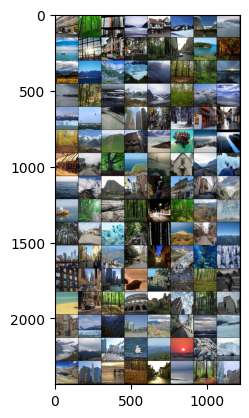

In [23]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Base Model For Image Classification

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [28]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [31]:
num_epochs = 2
opt_func = torch.optim.Adam
model =  NaturalSceneClassification()
lr = 0.001#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3275, val_loss: 1.2010, val_acc: 0.4981
Epoch [1], train_loss: 0.9360, val_loss: 2.6200, val_acc: 0.4104


In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)